# Phân khúc khách hàng bằng cách sử dụng Phân tích RFM và Phân cụm K-Means

In [ ]:

import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

from sklearn.cluster import KMeans

# Evaluation
from sklearn.metrics import silhouette_score

#Scaling
from sklearn.preprocessing import StandardScaler



In [ ]:

olist_order = pd.read_csv(r'./olist_orders_dataset.csv')
olist_item = pd.read_csv(r'./olist_order_items_dataset.csv')
olist_payment = pd.read_csv(r'./olist_order_payments_dataset.csv')
olist_product = pd.read_csv(r'./olist_products_dataset.csv')
olist_customer = pd.read_csv(r'./olist_customers_dataset.csv')
olist_review = pd.read_csv(r'./olist_order_reviews_dataset.csv')
olist_translate = pd.read_csv(r'./product_category_name_translation.csv')

In [ ]:

df_olist = pd.merge(olist_order, olist_item, on='order_id', how='left')
df_olist = pd.merge(df_olist, olist_product, on='product_id', how='inner')
df_olist = pd.merge(df_olist, olist_payment, on='order_id', how = 'left')
df_olist = pd.merge(df_olist, olist_review, on='order_id', how='left')
df_olist = pd.merge(df_olist, olist_customer, on='customer_id', how='right')
df_olist = pd.merge(df_olist, olist_translate, on='product_category_name', how='inner')

In [ ]:
df_olist.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name_english
0,00e7ee1b050b8499577073aeb2a297a1,06b8999e2fba1a1fbc88172c00ba8bc7,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1.0,a9516a079e37a9c9c36b9b78b10169e8,...,4.0,NaN,NaN,2017-05-26 00:00:00,2017-05-30 22:34:40,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,office_furniture
1,b2059ed67ce144a36e2aa97d2c9e9ad2,4e7b3e00288586ebd08712fdd0374a03,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,1.0,bd07b66896d6f1494f5b86251848ced7,...,5.0,NaN,NaN,2018-06-15 00:00:00,2018-06-15 12:10:59,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,office_furniture
2,951670f92359f4fe4a63112aa7306eba,b2b6027bc5c5109e529d4dc6358b12c3,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,1.0,a5647c44af977b148e0a3a4751a09e2e,...,5.0,NaN,NaN,2018-03-29 00:00:00,2018-04-02 18:36:47,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,office_furniture
3,997fd4b37386d10b57d4ac8cdec011a6,4c06b42fbf7b97ab10779cda5549cd1c,delivered,2018-07-08 09:59:19,2018-07-08 10:30:15,2018-07-25 15:12:00,2018-08-08 19:42:53,2018-08-16 00:00:00,1.0,8ed094bfe076c568f6bb10feada3f75d,...,1.0,Nada de produto,"Ainda não recebi o produto. Sendo assim, não p...",2018-08-09 00:00:00,2018-08-14 11:40:54,07d190f123147d9e89d4b922543d7948,65075,sao luis,MA,office_furniture
4,b63fff1ef8b6201df68bb611ee41129e,8276de07ef25225d412b8462d73f8664,delivered,2017-04-02 22:15:27,2017-04-04 05:55:19,2017-04-13 16:28:06,2017-05-02 13:53:25,2017-05-08 00:00:00,1.0,aba86c093ccdbac75b09111d57e50004,...,4.0,NaN,"A crítica é à entrega, pois por se tratar dos ...",2017-05-03 00:00:00,2017-05-03 21:06:33,332cf4e83e16004ba7dca932ce82475b,90010,porto alegre,RS,office_furniture


# Làm sạch dũ liệu

## Loại bỏ các cột không cần thiết

In [ ]:
df_olist_clean = df_olist.drop(columns=['order_status', 'order_approved_at', 'order_delivered_customer_date', 'order_delivered_carrier_date', 'order_delivered_customer_date',
                                  'order_estimated_delivery_date', 'seller_id', 'shipping_limit_date','product_category_name', 'product_name_lenght',
                                  'product_description_lenght', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm',
                                  'payment_installments','review_id', 'review_comment_title', 'review_comment_message', 'review_creation_date',
                                  'review_answer_timestamp', 'customer_id', 'customer_city', 'customer_state', 'product_photos_qty', 'freight_value', 'payment_sequential'])

## Kiểm tra giá trị bị thiếu

In [ ]:
df_olist_clean.isnull().sum()

order_id                         0
order_purchase_timestamp         0
order_item_id                    0
product_id                       0
price                            0
payment_type                     3
payment_value                    3
review_score                     0
customer_unique_id               0
customer_zip_code_prefix         0
product_category_name_english    0
dtype: int64

In [ ]:
df_olist_clean[df_olist_clean['payment_type'].isnull()]

,order_id,order_purchase_timestamp,order_item_id,product_id,price,payment_type,payment_value,review_score,customer_unique_id,customer_zip_code_prefix,product_category_name_english
51505,bfbd0f9bdef84302105ad712db648a6c,2016-09-15 12:16:38,1.0,5a6b04657a4c5ee34285d1e4619a96b4,44.99,NaN,NaN,1.0,830d5b7aaa3b6f1e9ad63703bec97d23,14600,health_beauty
51506,bfbd0f9bdef84302105ad712db648a6c,2016-09-15 12:16:38,2.0,5a6b04657a4c5ee34285d1e4619a96b4,44.99,NaN,NaN,1.0,830d5b7aaa3b6f1e9ad63703bec97d23,14600,health_beauty
51507,bfbd0f9bdef84302105ad712db648a6c,2016-09-15 12:16:38,3.0,5a6b04657a4c5ee34285d1e4619a96b4,44.99,NaN,NaN,1.0,830d5b7aaa3b6f1e9ad63703bec97d23,14600,health_beauty


In [ ]:
df_olist_clean.dropna(inplace = True)

In [ ]:
df_olist_clean.isnull().sum()

order_id                         0
order_purchase_timestamp         0
order_item_id                    0
product_id                       0
price                            0
payment_type                     0
payment_value                    0
review_score                     0
customer_unique_id               0
customer_zip_code_prefix         0
product_category_name_english    0
dtype: int64

## Kiểm tra giá trị bị trùng lặp:

In [ ]:
df_olist_clean.duplicated().sum()

1072

In [ ]:
df_olist_clean[df_olist_clean.duplicated()].head()

,order_id,order_purchase_timestamp,order_item_id,product_id,price,payment_type,payment_value,review_score,customer_unique_id,customer_zip_code_prefix,product_category_name_english
53,5040757d4e06a4be96d3827b860b4e7c,2017-10-20 23:02:08,1.0,f80214fd7d681d1dcf12b3acaf4f0da7,196.99,credit_card,253.65,5.0,8746f1ba2e19bcf8bc03a946a0923d78,83511,office_furniture
93,86f353da4086de44a6acd7faf109e47d,2017-07-13 22:29:41,1.0,0364c36f8e845e4d309c0a3accc04b1c,209.99,voucher,25.00,5.0,e66c03faee607e9eb86380d0a86a327d,21073,office_furniture
94,86f353da4086de44a6acd7faf109e47d,2017-07-13 22:29:41,1.0,0364c36f8e845e4d309c0a3accc04b1c,209.99,voucher,25.00,5.0,e66c03faee607e9eb86380d0a86a327d,21073,office_furniture
95,86f353da4086de44a6acd7faf109e47d,2017-07-13 22:29:41,1.0,0364c36f8e845e4d309c0a3accc04b1c,209.99,voucher,25.00,5.0,e66c03faee607e9eb86380d0a86a327d,21073,office_furniture
96,86f353da4086de44a6acd7faf109e47d,2017-07-13 22:29:41,1.0,0364c36f8e845e4d309c0a3accc04b1c,209.99,voucher,25.00,5.0,e66c03faee607e9eb86380d0a86a327d,21073,office_furniture


In [ ]:
df_olist_clean = df_olist_clean.drop_duplicates()

## Xem info

In [ ]:
df_olist_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115509 entries, 0 to 116583
Data columns (total 11 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       115509 non-null  object 
 1   order_purchase_timestamp       115509 non-null  object 
 2   order_item_id                  115509 non-null  float64
 3   product_id                     115509 non-null  object 
 4   price                          115509 non-null  float64
 5   payment_type                   115509 non-null  object 
 6   payment_value                  115509 non-null  float64
 7   review_score                   115509 non-null  float64
 8   customer_unique_id             115509 non-null  object 
 9   customer_zip_code_prefix       115509 non-null  int64  
 10  product_category_name_english  115509 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 10.6+ MB


In [ ]:

df_olist_clean['order_purchase_timestamp'] = pd.to_datetime(df_olist_clean['order_purchase_timestamp'])
df_olist_clean['order_purchase_timestamp'].dt.strftime('%Y-%m-%d')

df_olist_clean['month_order'] = df_olist_clean['order_purchase_timestamp'].dt.month_name()
df_olist_clean['weekday_order'] = df_olist_clean['order_purchase_timestamp'].dt.day_name()
df_olist_clean['month_year_order'] = df_olist_clean['order_purchase_timestamp'].dt.to_period('M').astype(str)
df_olist_clean['date_order'] = df_olist_clean['order_purchase_timestamp'].dt.day

In [ ]:
df_olist_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115509 entries, 0 to 116583
Data columns (total 15 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115509 non-null  object        
 1   order_purchase_timestamp       115509 non-null  datetime64[ns]
 2   order_item_id                  115509 non-null  float64       
 3   product_id                     115509 non-null  object        
 4   price                          115509 non-null  float64       
 5   payment_type                   115509 non-null  object        
 6   payment_value                  115509 non-null  float64       
 7   review_score                   115509 non-null  float64       
 8   customer_unique_id             115509 non-null  object        
 9   customer_zip_code_prefix       115509 non-null  int64         
 10  product_category_name_english  115509 non-null  object        
 11  month

## Xử lý các biến không nhất quán

In [ ]:
def format_val(x):
  if x == 'home_appliances_2':
    return "home_appliances"
  elif x == 'home_confort':
    return "home_comfort"
  elif x == "home_comfort_2":
    return "home_comfort"

  return x

df_olist_clean['product_category_name_english'] = df_olist_clean['product_category_name_english'].apply(format_val)

# EDA - Order Transaction


In [ ]:
df = df_olist_clean.copy()

In [ ]:
df.shape

(115509, 15)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115509 entries, 0 to 116583
Data columns (total 15 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115509 non-null  object        
 1   order_purchase_timestamp       115509 non-null  datetime64[ns]
 2   order_item_id                  115509 non-null  float64       
 3   product_id                     115509 non-null  object        
 4   price                          115509 non-null  float64       
 5   payment_type                   115509 non-null  object        
 6   payment_value                  115509 non-null  float64       
 7   review_score                   115509 non-null  float64       
 8   customer_unique_id             115509 non-null  object        
 9   customer_zip_code_prefix       115509 non-null  int64         
 10  product_category_name_english  115509 non-null  object        
 11  month

In [ ]:
df.nunique().sort_values(ascending=False)

order_id                         97255
order_purchase_timestamp         96720
customer_unique_id               94087
product_id                       32328
payment_value                    28765
customer_zip_code_prefix         14927
price                             5899
product_category_name_english       69
date_order                          31
month_year_order                    24
order_item_id                       21
month_order                         12
weekday_order                        7
review_score                         5
payment_type                         4
dtype: int64

In [ ]:
df.describe()

,order_purchase_timestamp,order_item_id,price,payment_value,review_score,customer_zip_code_prefix,date_order
count,115509,115509.000000,115509.000000,115509.000000,115509.000000,115509.00000,115509.000000
mean,2017-12-31 09:55:23.934983680,1.196747,120.830109,173.795383,4.016510,35067.93436,15.559030
min,2016-09-04 21:15:19,1.000000,0.850000,0.000000,1.000000,1003.00000,1.000000
25%,2017-09-12 17:47:51,1.000000,39.900000,61.700000,4.000000,11320.00000,8.000000
50%,2018-01-19 12:52:52,1.000000,74.900000,108.810000,5.000000,24325.00000,16.000000
75%,2018-05-04 16:44:14,1.000000,134.900000,190.430000,5.000000,58701.00000,23.000000
max,2018-09-03 09:06:57,21.000000,6735.000000,13664.080000,5.000000,99980.00000,31.000000
std,NaN,0.700518,184.032420,268.409558,1.398025,29814.41971,8.660957


##  Các biến phân loại

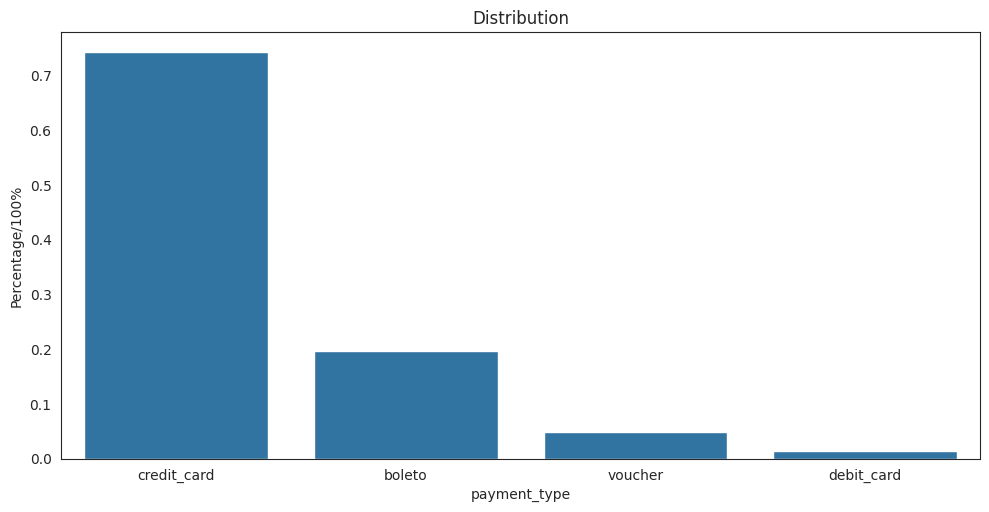

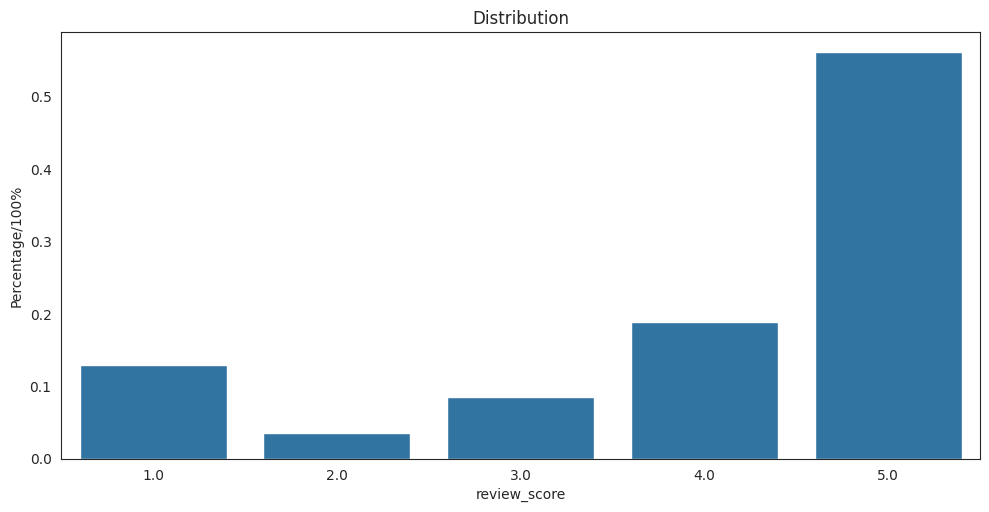

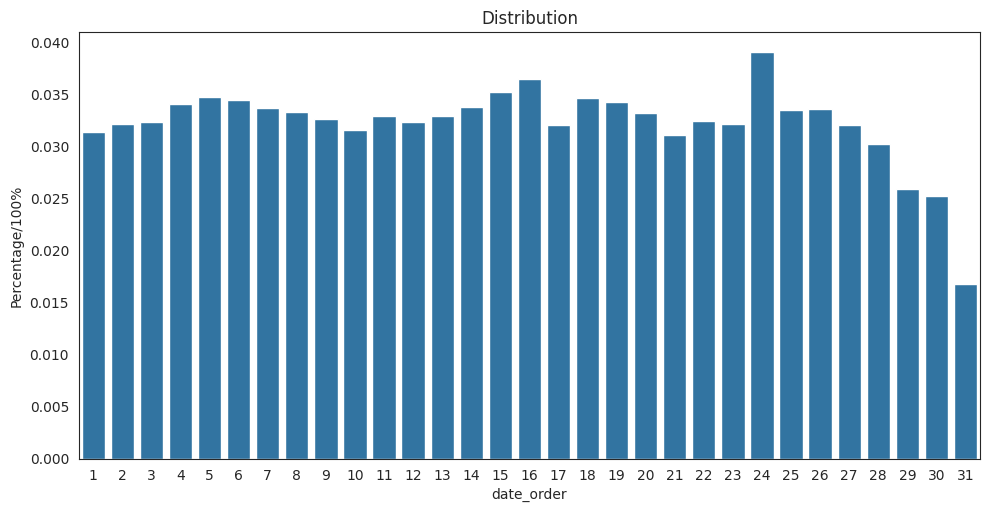

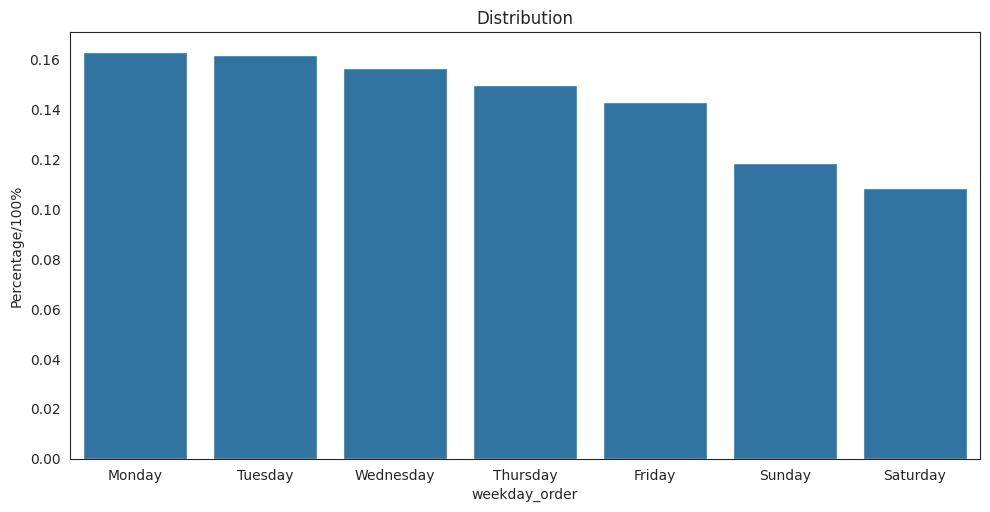

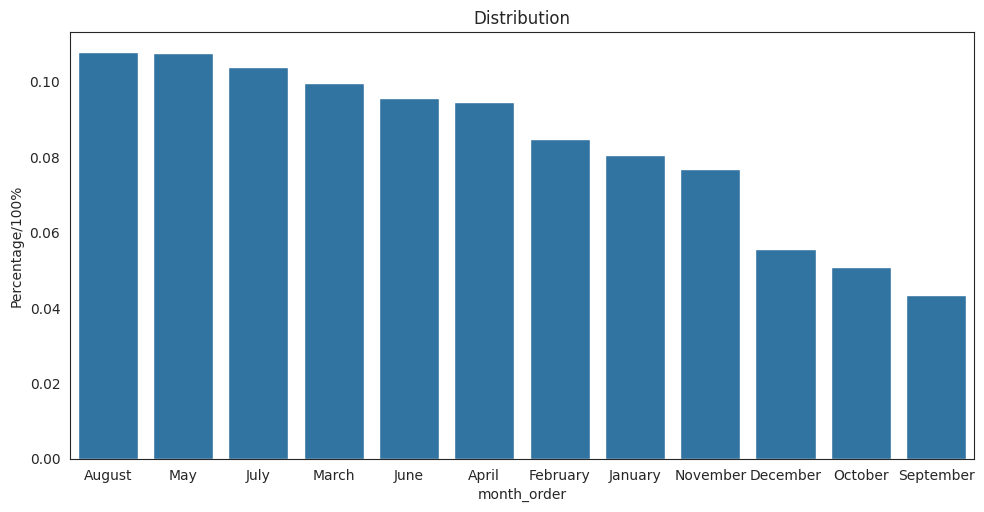

In [ ]:
for col in df[['payment_type', 'review_score', 'date_order', 'weekday_order', 'month_order']]:
    value_counts = df[col].value_counts(normalize=True)
    fig, axes = plt.subplots(figsize=(10,5))
    plot = sns.barplot(x = value_counts.index, y = value_counts)
    plt.tight_layout()
    axes.set_title('Distribution')
    axes.set_ylabel('Percentage/100%')
    axes.set_xlabel(col)
    plt.show()




- Loại thanh toán: ~74% giao dịch sử dụng thẻ tín dụng, ~20% giao dịch sử dụng boleto, ~9% giao dịch sử dụng phiếu thưởng và ~1% giao dịch sử dụng thẻ ghi nợ.
- Điểm đánh giá: ~55% giao dịch được cho điểm đánh giá là 5, ~19% giao dịch được cho điểm đánh giá là 4 và ~11% giao dịch được cho điểm đánh giá là 1. Điểm đánh giá thấp nhất là 2 và 3, với giao dịch dưới 10%.
- Thứ tự ngày: Hầu hết các giao dịch diễn ra vào ngày 24, với gần ~4% giao dịch
 trong tuần: Hầu hết các giao dịch diễn ra vào Thứ Hai, với gần ~16% giao dịch. Càng đến cuối tuần, số lượng đơn hàng càng giảm.
- Đơn hàng theo tháng: Hầu hết các giao dịch diễn ra vào tháng 8 và tháng 5, với gần ~12% giao dịch. Ít giao dịch nhất xảy ra vào tháng 10 và tháng 9, chỉ với ~5% giao dịch.

## Biến liên tục

price


<ipython-input-24-d8d2a300f397>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[[col]])


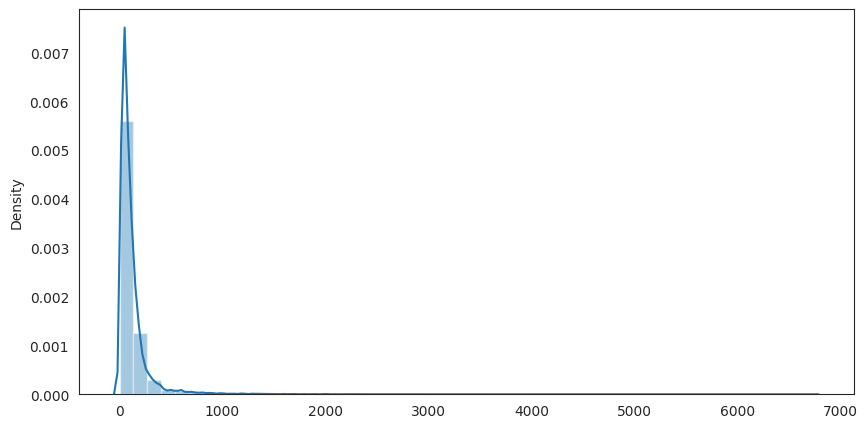

payment_value


<ipython-input-24-d8d2a300f397>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[[col]])


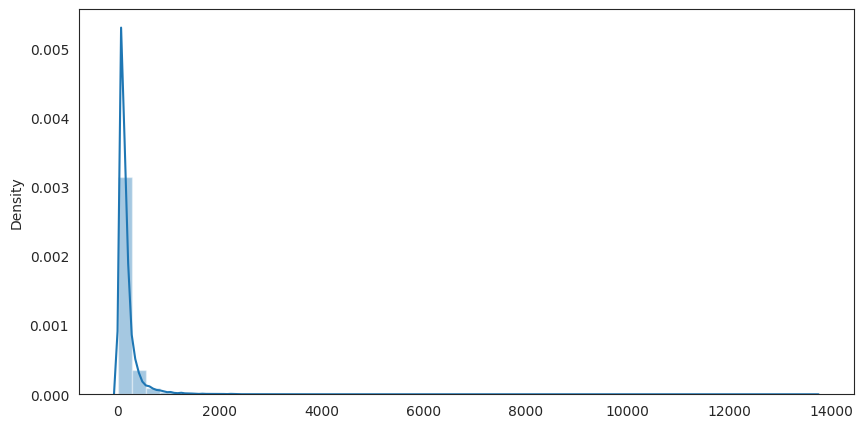

In [ ]:
for col in df[['price', 'payment_value']]:
    print(col)
    plt.figure(figsize=(10, 5))
    sns.distplot(df[[col]])
    plt.show()


- Giá trị thanh toán: Mức phân bổ nằm trong khoảng  R$1 - R$14,000. Số lượng giao dịch cao nhất nằm trong khoảngR$1 - R$200. Điều này có thể xảy ra do khách hàng có xu hướng mua hàng với giá phải chăng.

## Sản phẩm

In [ ]:
top_products = df.groupby("product_category_name_english").agg({"order_id": "count"}).sort_values("order_id", ascending=False).head(10)
top_products

,order_id
product_category_name_english,
bed_bath_table,11803
health_beauty,9933
sports_leisure,8904
furniture_decor,8753
computers_accessories,8104
housewares,7314
watches_gifts,6182
telephony,4692
garden_tools,4552


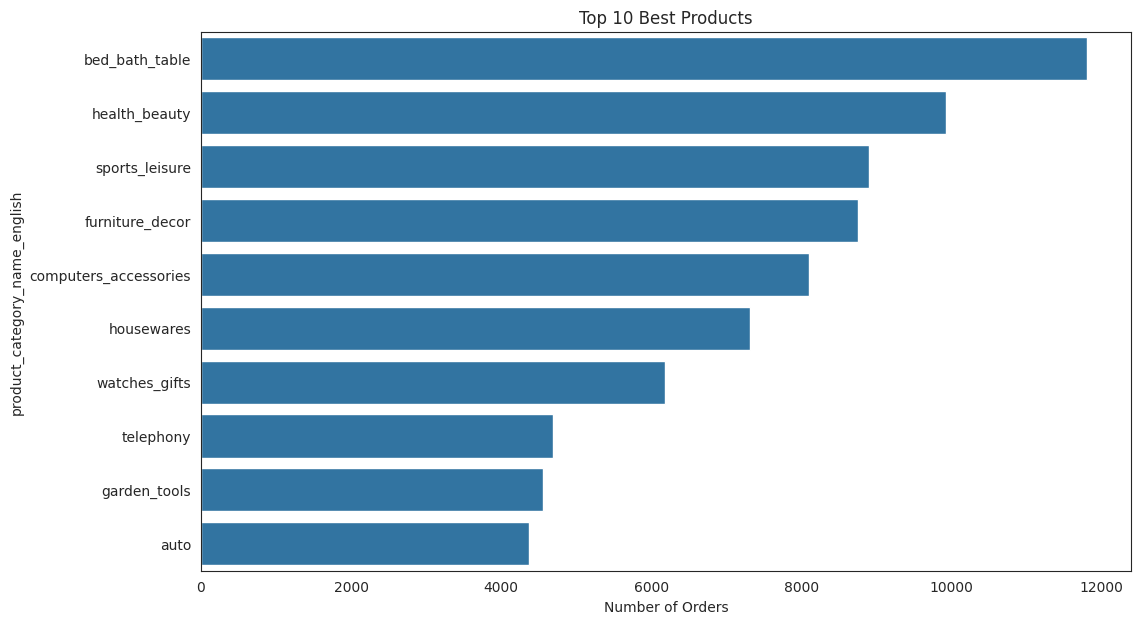

In [ ]:
plt.subplots(figsize=(12,7))
sns.barplot(x=top_products['order_id'], y=top_products.index)
plt.title('Top 10 Best Products')
plt.xlabel('Number of Orders')
plt.show()

- Danh mục sản phẩm được mua nhiều nhất là 'bed_bath_table' với tổng số lượt mua là 11.900 lần.
- 10 loại sản phẩm đó có thể được đội ngũ tiếp thị chú ý để tăng doanh thu.

## Order, Customer, and Total Payment by Month

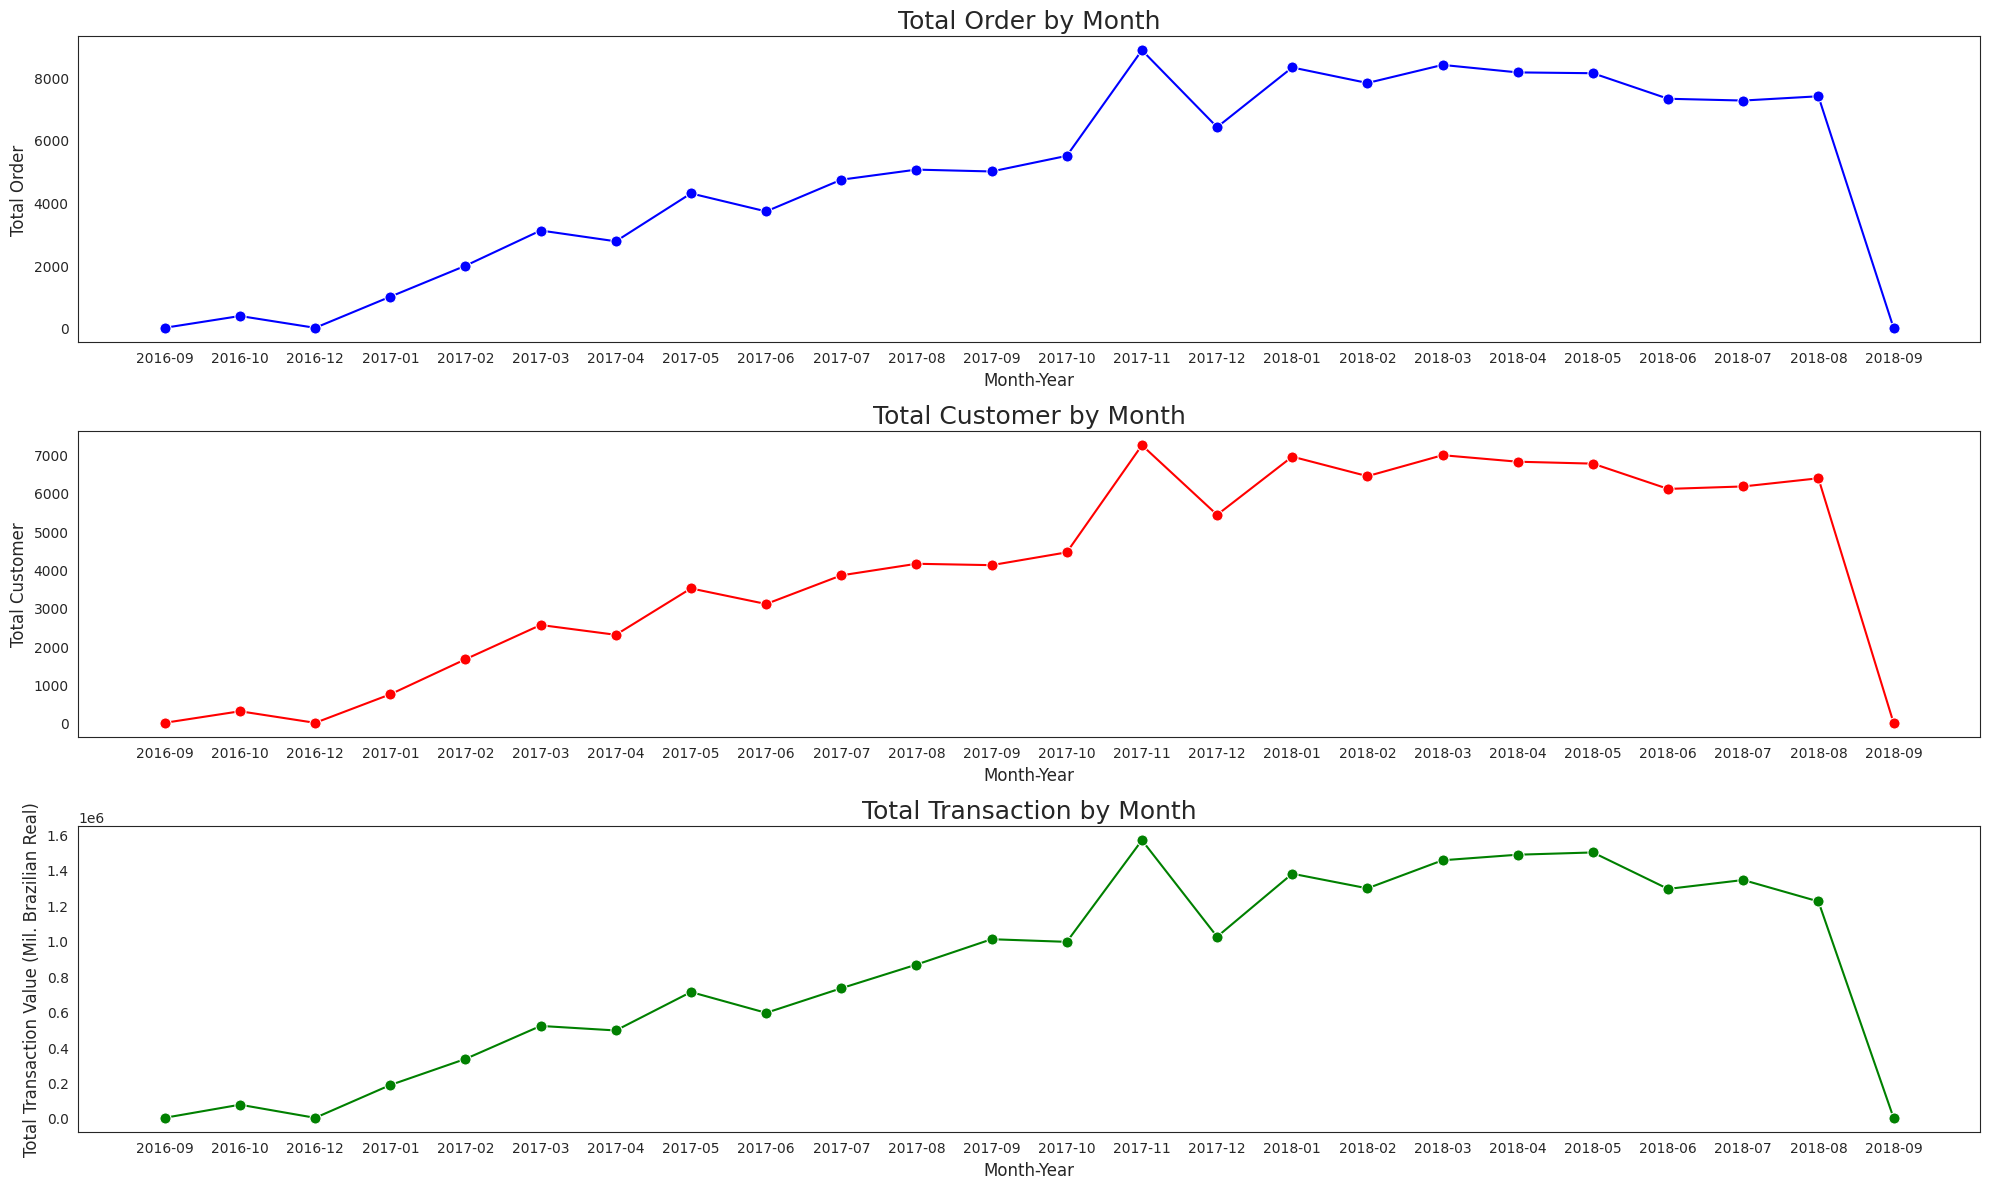

In [ ]:
# Group by order, customer, and transaction
order_per_month = df['order_id'].groupby(df['month_year_order']).count()
customer_per_month = df['customer_unique_id'].groupby(df['month_year_order']).nunique()
transaction_per_month = df['payment_value'].groupby(df['month_year_order']).sum()

# Visualization
plt.figure(figsize=(20, 12))

plt.subplot(311)
sns.lineplot(x=order_per_month.index, y=order_per_month.values, marker='o', markersize=8, color='blue')
plt.title('Total Order by Month', fontsize=18)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Total Order', fontsize=12)

plt.subplot(312)
sns.lineplot(x=customer_per_month.index, y=customer_per_month.values, marker='o', markersize=8, color='red')
plt.title('Total Customer by Month', fontsize=18)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Total Customer', fontsize=12)

plt.subplot(313)
sns.lineplot(x=transaction_per_month.index, y=transaction_per_month.values, marker='o', markersize=8, color='green')
plt.title('Total Transaction by Month', fontsize=18)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Total Transaction Value (Mil. Brazilian Real)', fontsize=12)

plt.tight_layout()
plt.show()

số lượng đơn đặt hàng, tổng số giao dịch và số lượng khách hàng cao nhất là vào tháng 11 năm 2017. Điều đó có thể xảy ra vì có ngày Black Friday đưa ra khuyến mãi trong tháng 11 để khách hàng mua quà Giáng sinh.
Đồ thị có xu hướng tăng dần từ năm 2016 đến năm 2017. Tuy nhiên, nó đã chững lại khi bước sang năm 2018.
Có sự bất thường/nhiễu động trong dữ liệu vào tháng 9 năm 2018, cho thấy sự sụt giảm đột ngột. Điều đó có thể xảy ra do việc thu thập dữ liệu đã kết thúc vào tháng đó nên dữ liệu được lấy không đầy đủ.

# EDA RFM
RFM là một kỹ thuật có thể được sử dụng để thực hiện Phân khúc khách hàng nhằm xác định hành vi mua hàng của khách hàng. Ý nghĩa của RFM là:

- Recency: Lần mua hàng gần nhất
- Frequency: tần suất giao dịch
- Monetary: Khả năng chi tiêu cả khách hàng

Bằng cách sử dụng RFM, các công ty có thể kích hoạt lại những khách hàng hiếm khi giao dịch, khiến khách hàng trung thành hơn, cải thiện các chiến lược tiếp thị để tăng doanh thu từ công ty.

In [ ]:

max_time = df['order_purchase_timestamp'].max() + dt.timedelta(1)

customer = df.groupby('customer_unique_id', as_index=False).agg(
  # Tinh toan khoang thoi gian mua hang gan nhat đến thời điểm lớn nhất trong dữ liệu
    recency =  ('order_purchase_timestamp', lambda x: (max_time-x.max()).days),
    frequency = ('order_id', 'count'),
    monetary =  ('payment_value', 'sum'),
    most_payment_type = ('payment_type', lambda x: x.value_counts().index[0]),
    avg_review_score = ('review_score', 'mean'),
    most_product_buy = ('product_category_name_english', lambda x: x.value_counts().index[0]),
)

In [ ]:
customer.shape

(94087, 7)

In [ ]:
customer.head()

,customer_unique_id,recency,frequency,monetary,most_payment_type,avg_review_score,most_product_buy
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,credit_card,5.0,bed_bath_table
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,credit_card,4.0,health_beauty
2,0000f46a3911fa3c0805444483337064,542,1,86.22,credit_card,3.0,stationery
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,credit_card,4.0,telephony
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,credit_card,5.0,telephony


## Recency

<ipython-input-31-621d4a795a98>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(customer['recency'], bins=30, color='paleturquoise')


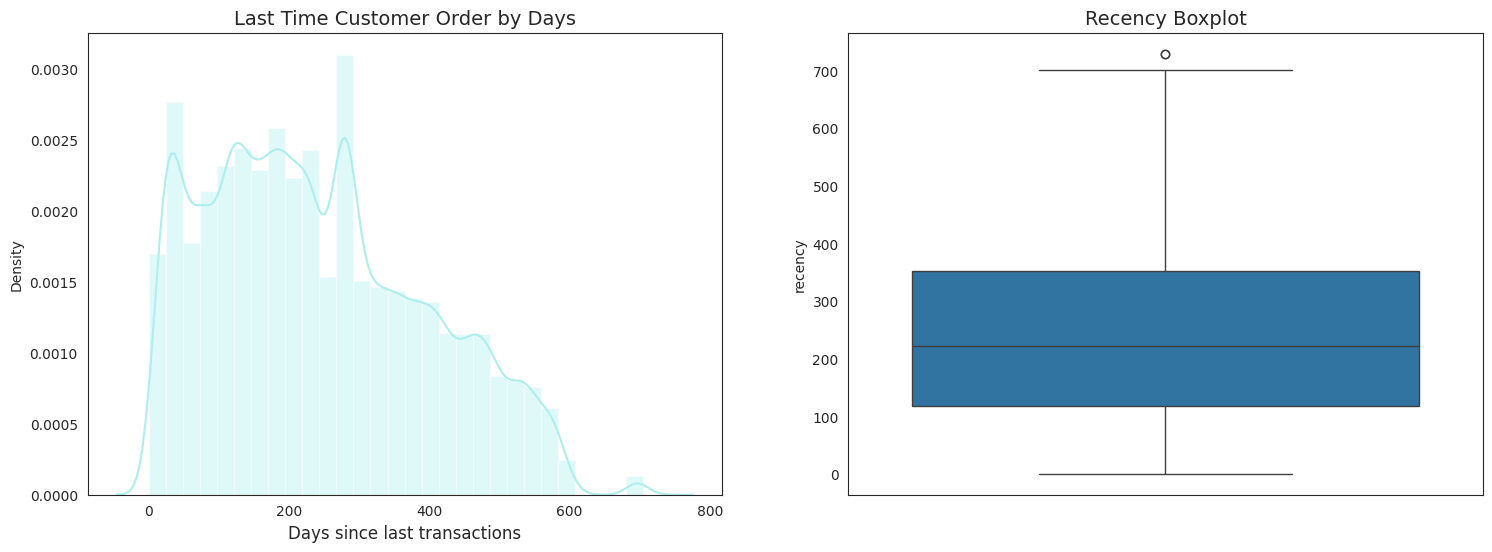

In [ ]:
plt.figure(figsize=(18, 6))
plt.subplot(121)
sns.distplot(customer['recency'], bins=30, color='paleturquoise')
plt.title('Last Time Customer Order by Days', fontsize=14)
plt.xlabel('Days since last transactions', fontsize=12)

plt.subplot(122)
sns.boxplot(customer['recency'])
plt.title('Recency Boxplot', fontsize=14)
plt.show()

plt.show()

In [ ]:
customer['recency'].describe()

count    94087.000000
mean       242.902558
std        153.156396
min          1.000000
25%        119.000000
50%        223.000000
75%        352.000000
max        729.000000
Name: recency, dtype: float64

## Frequency

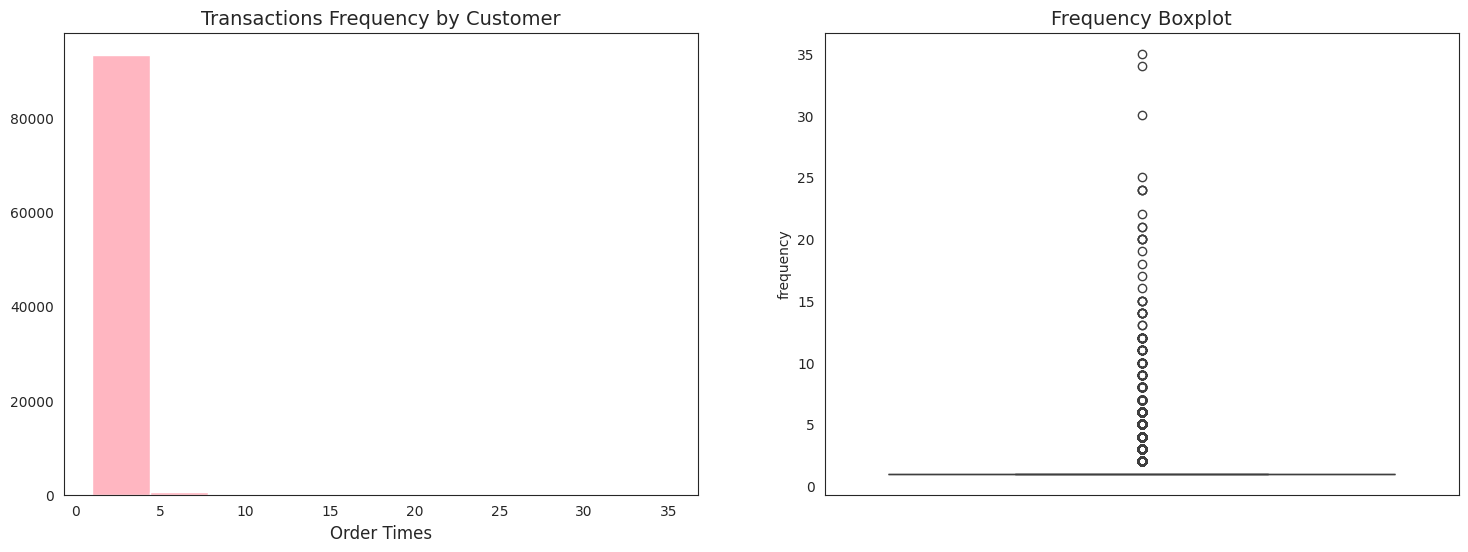

In [ ]:
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.hist(customer['frequency'].value_counts().index, weights=customer['frequency'].value_counts().values , color='lightpink' )
plt.title('Transactions Frequency by Customer', fontsize=14)
plt.xlabel('Order Times', fontsize=12)

plt.subplot(122)
sns.boxplot(customer['frequency'])
plt.title('Frequency Boxplot', fontsize=14)
plt.show()

plt.show()

In [ ]:
customer['frequency'].describe()

count    94087.000000
mean         1.227683
std          0.763923
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         35.000000
Name: frequency, dtype: float64

In [ ]:
customer['frequency'].value_counts()

frequency
1     79971
2     10568
3      1915
4       880
5       283
6       262
7        60
8        35
10       23
12       22
9        21
11       17
14        6
20        4
15        4
24        3
21        2
13        2
17        1
19        1
18        1
22        1
16        1
34        1
25        1
30        1
35        1
Name: count, dtype: int64

Dựa vào phân bố và thống kê mô tả tần suất:

- Mỗi khách hàng thường chỉ đặt hàng 1 lần khi sử dụng thương mại điện tử này. Vì vậy, cần phải tăng số lượng giao dịch được thực hiện bởi khách hàng bằng cách tiến hành tiếp thị có mục tiêu theo phân khúc của họ.
- Số lượng giao dịch tối đa của một khách hàng là 35 giao dịch.
- Số lượng giao dịch được thực hiện bởi mỗi khách hàng nằm trong khoảng từ 1 đến 35 giao dịch.

## Monetary

<ipython-input-35-1f856e96b24b>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(customer['monetary'], color= 'paleturquoise')


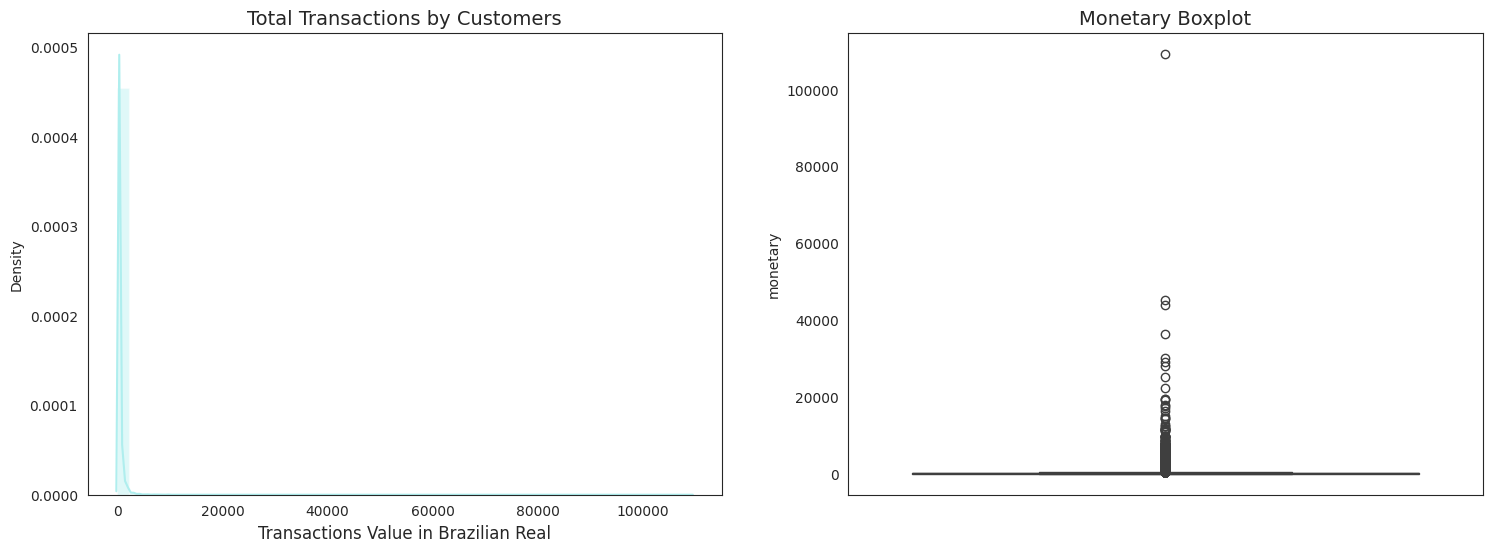

In [ ]:
plt.figure(figsize=(18, 6))
plt.subplot(121)
sns.distplot(customer['monetary'], color= 'paleturquoise')
plt.title('Total Transactions by Customers', fontsize=14)
plt.xlabel('Transactions Value in Brazilian Real', fontsize=12)

plt.subplot(122)
sns.boxplot(customer['monetary'])
plt.title('Monetary Boxplot', fontsize=14)
plt.show()

plt.show()

In [ ]:
customer['monetary'].describe()

count     94087.000000
mean        213.365618
std         644.518901
min           8.860000
25%          63.815000
50%         112.940000
75%         203.080000
max      109312.640000
Name: monetary, dtype: float64

Căn cứ vào sự phân bố và thống kê mô tả của tiền tệ:
Sự chênh lệch đáng kể giữa trung vị (112.94) và giá trị trung bình (213.37) cùng với độ lệch chuẩn cao (644.52) cho thấy dữ liệu có xu hướng bị lệch phải, tức là có một số giá trị rất cao so với phần lớn các mẫu khác.
Dữ liệu có sự phân bố rộng, biểu thị sự đa dạng cao về giá trị mà các mẫu quan sát mang lại.

# Phân cụm K-Means


In [ ]:

x = customer[['recency', 'frequency', 'monetary']]

# Scaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [ ]:
# Calculate Within Cluster Sum Squares (WCSS)
WCSS = []

for i in range(2,10):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=11)
    kmeans.fit(x_scaled)
    WCSS.append(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

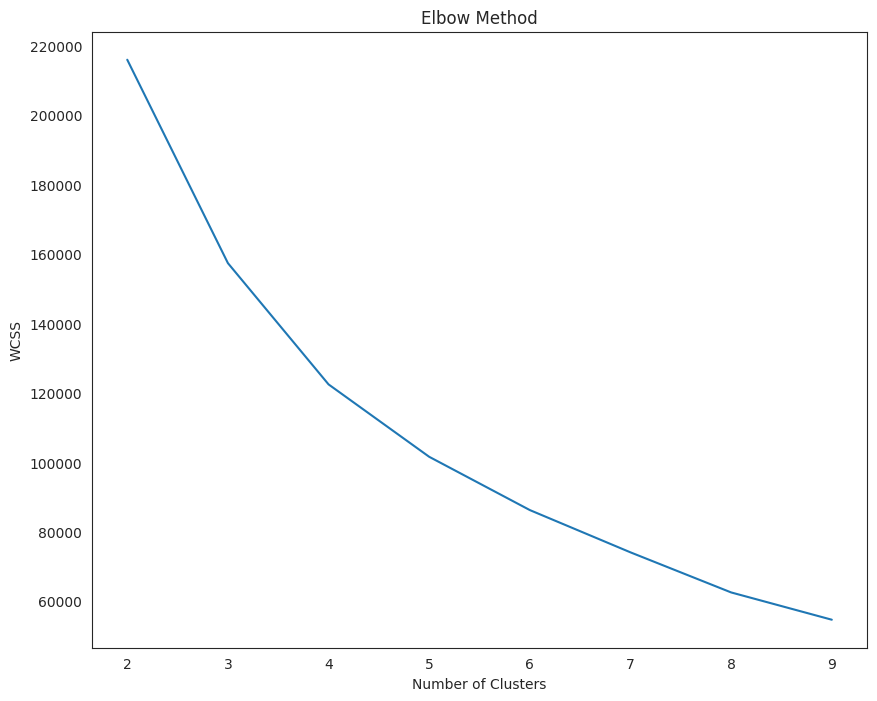

In [ ]:
# Elbow Method
plt.figure(figsize=(10,8))
plt.plot(range(2,10), WCSS)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

In [ ]:
# Silhoutte Score
score = []

for i in range(2,9):
  kmeans = KMeans(i)
  kmeans.fit(x_scaled)

  label = kmeans.labels_
  score.append(silhouette_score(x_scaled, label, metric = 'euclidean'))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Ta chọn 4 cụm để gán nhãn

In [ ]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=11)
kmeans.fit(x_scaled)

customer['label_kmeans'] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# Kết quả phân cụm K-means



In [ ]:
segment_analysis = customer.groupby(['label_kmeans'])[['recency', 'frequency', 'monetary']].mean()
segment_analysis

,recency,frequency,monetary
label_kmeans,,,
0,392.978179,1.119665,170.488908
1,236.808683,3.971989,1141.964465
2,132.469855,1.115336,170.771422
3,207.850000,11.400000,27733.938000


- 0:Khách hàng lâu ngày không thực hiện giao dịch, chỉ thực hiện 1 giao dịch và tổng số giao dịch thấp nhất. Chúng ta có thể gọi nó **Lost Customers**
- 1: Khách hàng gần đây thực hiện giao dịch, nhiều hơn 1 giao dịch và tổng số giao dịch cao. Chúng ta có thể gọi nó **Loyal Customers**
- 2: Khách hàng mới thực hiện giao dịch chỉ thực hiện 1 giao dịch và tổng số giao dịch thấp. Chúng ta có thể gọi nó **New Customers**
- 3:Khách hàng thực hiện giao dịch gần đây, nhiều hơn 1 giao dịch và có tổng giao dịch cao nhất. Chúng ta có thể gọi nó **Best Customers**

In [ ]:
segment_analysis.rename({
    0:'Lost Customers',
    1:'Loyal Customers',
    2:'New Customers',
    3:'Best Customers'
})

,recency,frequency,monetary
label_kmeans,,,
Lost Customers,392.978179,1.119665,170.488908
Loyal Customers,236.808683,3.971989,1141.964465
New Customers,132.469855,1.115336,170.771422
Best Customers,207.850000,11.400000,27733.938000


In [ ]:
# Labeling
customer['labels'] = customer['label_kmeans'].map({
    0:'Lost Customers',
    1:'Loyal Customers',
    2:'New Customers',
    3:'Best Customers'
})

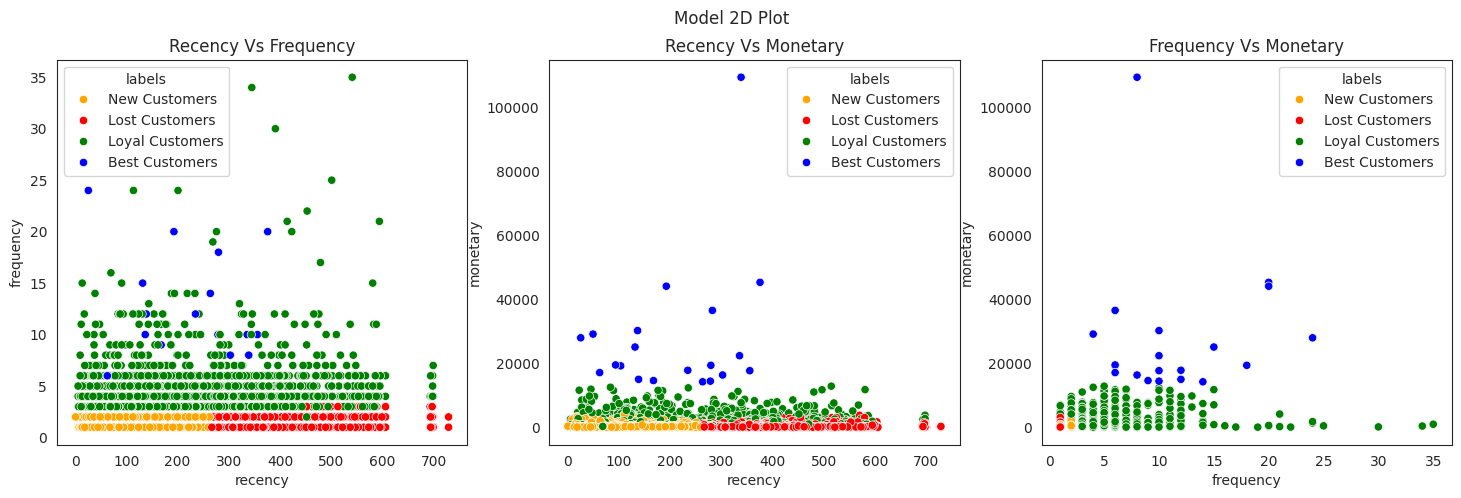

In [ ]:
# 2D Scatter Plot
plt.figure(figsize =(18,5))

# Recency vs Frequency
plt.subplot(131)
sns.scatterplot(x = 'recency', y = 'frequency', hue = 'labels', data = customer, palette=['orange', 'red', 'green', 'blue'])
plt.title('Recency Vs Frequency')

# Recency Vs Monetary
plt.subplot(132)
sns.scatterplot(x = 'recency', y = 'monetary', hue = 'labels', data = customer, palette=['orange', 'red', 'green', 'blue'])
plt.title('Recency Vs Monetary')

# Frequency Vs Monetary
plt.subplot(133)
sns.scatterplot(x = 'frequency', y = 'monetary', hue = 'labels', data = customer, palette=['orange', 'red', 'green', 'blue'])
plt.title('Frequency Vs Monetary')

plt.suptitle('Model 2D Plot')
plt.savefig('./customer_segments.png')
plt.show()


1. Recency vs Frequency:
   - Trục x được ghi là "recency" và dao động từ 0 đến hơn 30.
   - Trục y được ghi là "frequency" và dao động từ 0 đến hơn 30.
   - New Customers chủ yếu tập trung trong khoảng recency thấp (gần 0) và trải đều qua một loạt các giá trị frequency.
   - Loyal Customers phân tán trên nhiều giá trị recency khác nhau nhưng chủ yếu tập trung ở phạm vi frequency cao.
   - Lost Customers phân tán chủ yếu ở các giá trị recency cao, cho thấy họ không thực hiện mua sắm gần đây, với một phạm vi frequency khá rộng.
   - Best Customers được tìm thấy ở phạm vi recency thấp và frequency cao, cho thấy họ đã thực hiện mua sắm gần đây và thường xuyên.

2. Recency vs Monetary:
   - Trục x được ghi là "recency" và có phạm vi giống như biểu đồ đầu tiên.
   - Trục y được ghi là "monetary" và dao động từ 0 đến hơn 70000.
   - New Customers phân bố trên một loạt giá trị monetary nhưng tập trung ở các giá trị recency thấp.
   - Loyal Customers phân tán trên các giá trị monetary khác nhau mà không có mẫu rõ ràng liên quan đến recency.
   - Lost Customers chủ yếu tìm thấy ở phạm vi recency cao, cho thấy tương tác không thường xuyên, với giá trị monetary đa dạng.
   - Best Customers tập trung ở phạm vi recency thấp, với một số giá trị monetary cao nhất được đại diện trên biểu đồ.

3. Frequency vs Monetary:
   - Trục x được ghi là "frequency" và dao động từ 0 đến hơn 30.
   - Trục y được ghi là "monetary" và dao động từ 0 đến hơn 70000, tương tự như biểu đồ thứ hai.
   - New Customers phân bố trên biểu đồ mà không có mẫu rõ ràng giữa frequency và giá trị monetary.
   - Loyal Customers chủ yếu tìm thấy ở phạm vi frequency cao, với một loạt giá trị monetary.
   - Lost Customers xuất hiện ở các frequency khác nhau nhưng với một xu hướng tổng thể của giá trị monetary thấp.
   - Best Customers được tìm thấy ở phạm vi frequency cao và cũng có một số giá trị monetary cao nhất.

In [ ]:
customer['labels'].value_counts()

labels
New Customers      52048
Lost Customers     38449
Loyal Customers     3570
Best Customers        20
Name: count, dtype: int64

<ipython-input-47-f6504361cdbe>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plots = sns.countplot(x='labels', data = customer, palette=['orange', 'red', 'green', 'blue'])


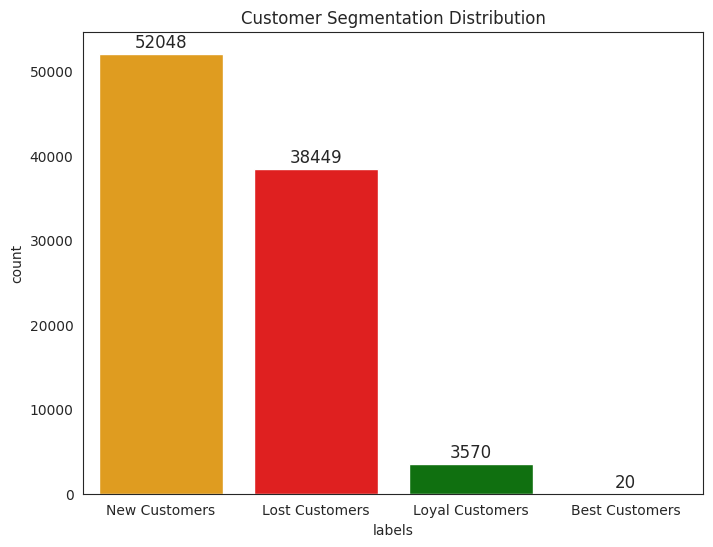

In [ ]:
## Phân bổ phân khúc khách hàng
plt.figure(figsize = (8,6))
plots = sns.countplot(x='labels', data = customer, palette=['orange', 'red', 'green', 'blue'])
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x()+ bar.get_width()/2,
                    bar.get_height()), ha='center', va='center',
                   size=12,xytext=(0,8),
                   textcoords='offset points')
plt.title('Customer Segmentation Distribution')
plt.show()

c# Cluster Analysis

In [ ]:

rfm_segment = customer.groupby(['labels', 'label_kmeans']).agg(
    n_customer = ('customer_unique_id', 'count'),
    mean_recency =  ('recency', 'mean'),
    min_recency = ('recency', 'min'),
    max_rencency = ('recency', 'max'),
    mean_freq = ('frequency', 'mean'),
    min_freq = ('frequency', 'min'),
    max_freq = ('frequency', 'max'),
    mean_monetary =  ('monetary', 'mean'),
    min_monetary = ('monetary', 'min'),
    max_monetary = ('monetary', 'max'),
    most_payment_type = ('most_payment_type', lambda x: x.value_counts().index[0]),
    most_product_buy = ('most_product_buy', lambda x: x.value_counts().index[0]),
).sort_values(by='n_customer')

rfm_segment

,,n_customer,mean_recency,min_recency,max_rencency,mean_freq,min_freq,max_freq,mean_monetary,min_monetary,max_monetary,most_payment_type,most_product_buy
labels,label_kmeans,,,,,,,,,,,,
Best Customers,3,20,207.850000,26,376,11.400000,4,24,27733.938000,14196.28,109312.64,credit_card,computers_accessories
Loyal Customers,1,3570,236.808683,6,699,3.971989,1,35,1141.964465,12.29,12834.50,credit_card,furniture_decor
Lost Customers,0,38449,392.978179,263,729,1.119665,1,3,170.488908,8.86,4016.91,credit_card,bed_bath_table
New Customers,2,52048,132.469855,1,262,1.115336,1,2,170.771422,9.59,4163.51,credit_card,health_beauty


Conclusion:
1. **Best Customers**:
- Bao gồm 20 khách hàng có vừa thực hiện giao dịch gần đây và có tổng số tiền giao dịch cao nhất.
Trung bình, nhóm khách hàng này chi khoảng R$27,733 trên 11 giao dịch, với lần mua gần nhất cách đây khoảng 207 ngày.
Họ chủ yếu mua các phụ kiện máy tính bằng phương thức thanh toán bằng thẻ tín dụng.

- Chiến lược phù hợp cho nhóm này bao gồm chương trình tín dụng, đề xuất sản phẩm mới và ưu đãi đặc biệt để khuyến khích bán hàng và bán hàng xuyên suốt.


2. **Loyal Customers**:
- Với 3,570 khách hàng, nhóm này đại diện cho những người đã mua hàng gần đây nhiều lần với tổng số tiền giao dịch lớn.
Số tiền trung bình mỗi khách hàng là khoảng R$1,141 trên 4 giao dịch, với lần mua gần nhất cách đây khoảng 236 ngày.
Họ chủ yếu mua trong danh mục trang trí nội thất bằng phương thức thanh toán bằng thẻ tín dụng.
- Chiến lược phù hợp cho nhóm này bao gồm chương trình tín dụng, điểm thưởng, và đề xuất sản phẩm mới để tăng doanh số bán hàng và bán hàng xuyên suốt.

3. **New Customers**:
- Nhóm lớn nhất với 52,048 khách hàng bao gồm những người đã thực hiện giao dịch 1 lần thôi gần đây với tổng số tiền thấp.
Trung bình, những khách hàng này chi khoảng R$170 trong mỗi giao dịch, với số giao dịch trung bình là 1 và lần mua cuối cùng cách đây khoảng 132 ngày.
Họ thích mua trong danh mục sức khỏe và làm đẹp và thường chọn phương thức thanh toán bằng thẻ tín dụng.

- Chiến lược cho nhóm này bao gồm gửi email chào mừng, ưu đãi chương trình tín dụng, và phiếu giảm giá để tạo mối quan hệ và khuyến khích bán hàng và bán hàng xuyên suốt.

4. **Lost Customers**:
- Bao gồm 38,449 khách hàng, nhóm này bao gồm những người không thực hiện giao dịch gần đây, thực hiện chỉ 1 giao dịch và chi tiêu tổng cộng thấp.
Giá trị giao dịch trung bình là R$170, chỉ xảy ra 1 lần trung bình, với lần mua cuối cùng xảy ra khoảng 132 ngày trước.
Những khách hàng này thường mua các sản phẩm giường, bàn và bếp bằng phương thức thanh toán bằng thẻ tín dụng.
- Chiến lược hiệu quả để tương tác với nhóm này bao gồm cung cấp các ưu đãi giới hạn thường xuyên, phiếu giảm giá,  chiến dịch qua email và yêu cầu phản hồi để giữ và tái kích hoạt đối với nhóm khách hàng